In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/
Meshcat url:  http://127.0.0.1:7001/static/


In [3]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "cup": Cup,
        "bowl": Bowl,
        "plate": Plate,
        "bin": DishBin
    }
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

[2021-09-21 23:55:31.735] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Saving...
Loading...


In [14]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [16]:
# Try to fit parameters
svi = SVIWrapper(grammar, observed_node_sets)
svi.do_iterated_vi_fitting(major_iterations=1, minor_iterations=150, base_lr=0.1, tqdm=tqdm, num_elbo_samples=1, clip=None)

No handles with labels found to put in legend.


Desk
Final params:  tensor([0.2000])
0:xyz:mean final: tensor([-0.0104,  0.0459,  0.0600])
0:xyz:variance final: tensor([0.0061, 0.0262, 0.0023])


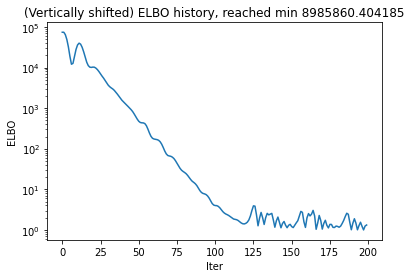

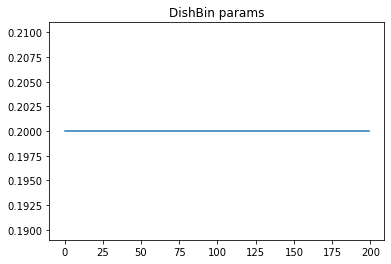

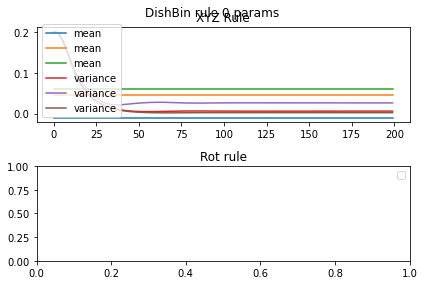

In [17]:
svi.plot_elbo_history()
print("Desk")
svi.plot_grammar_parameter_history(DishBin)

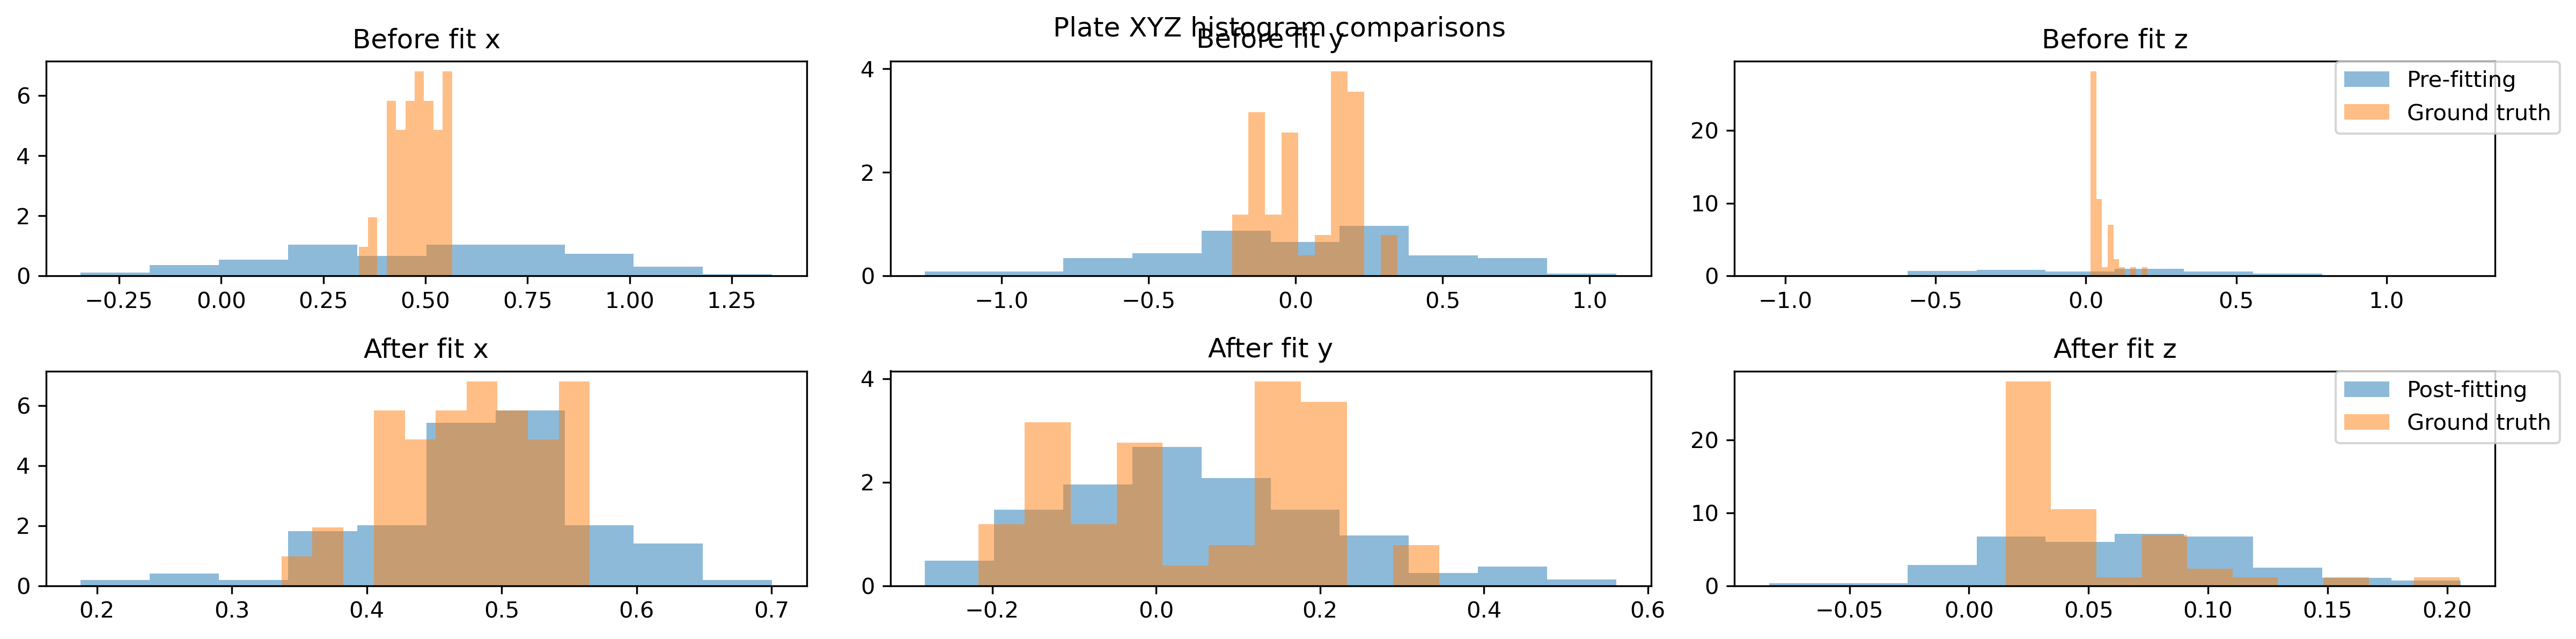

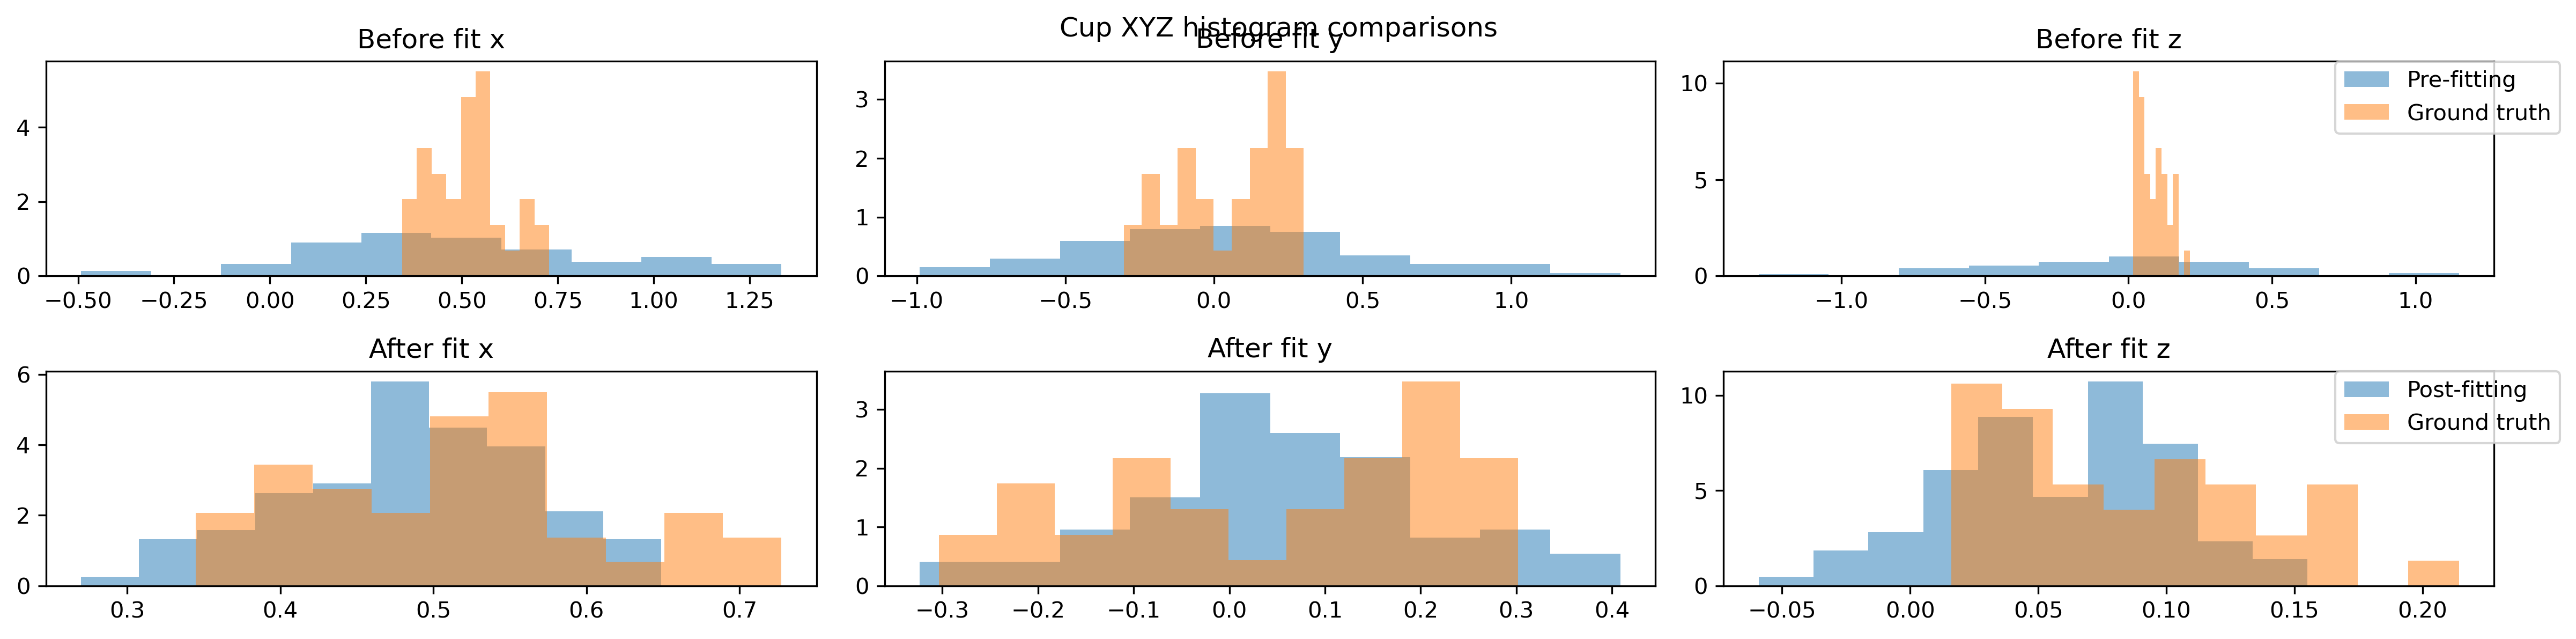

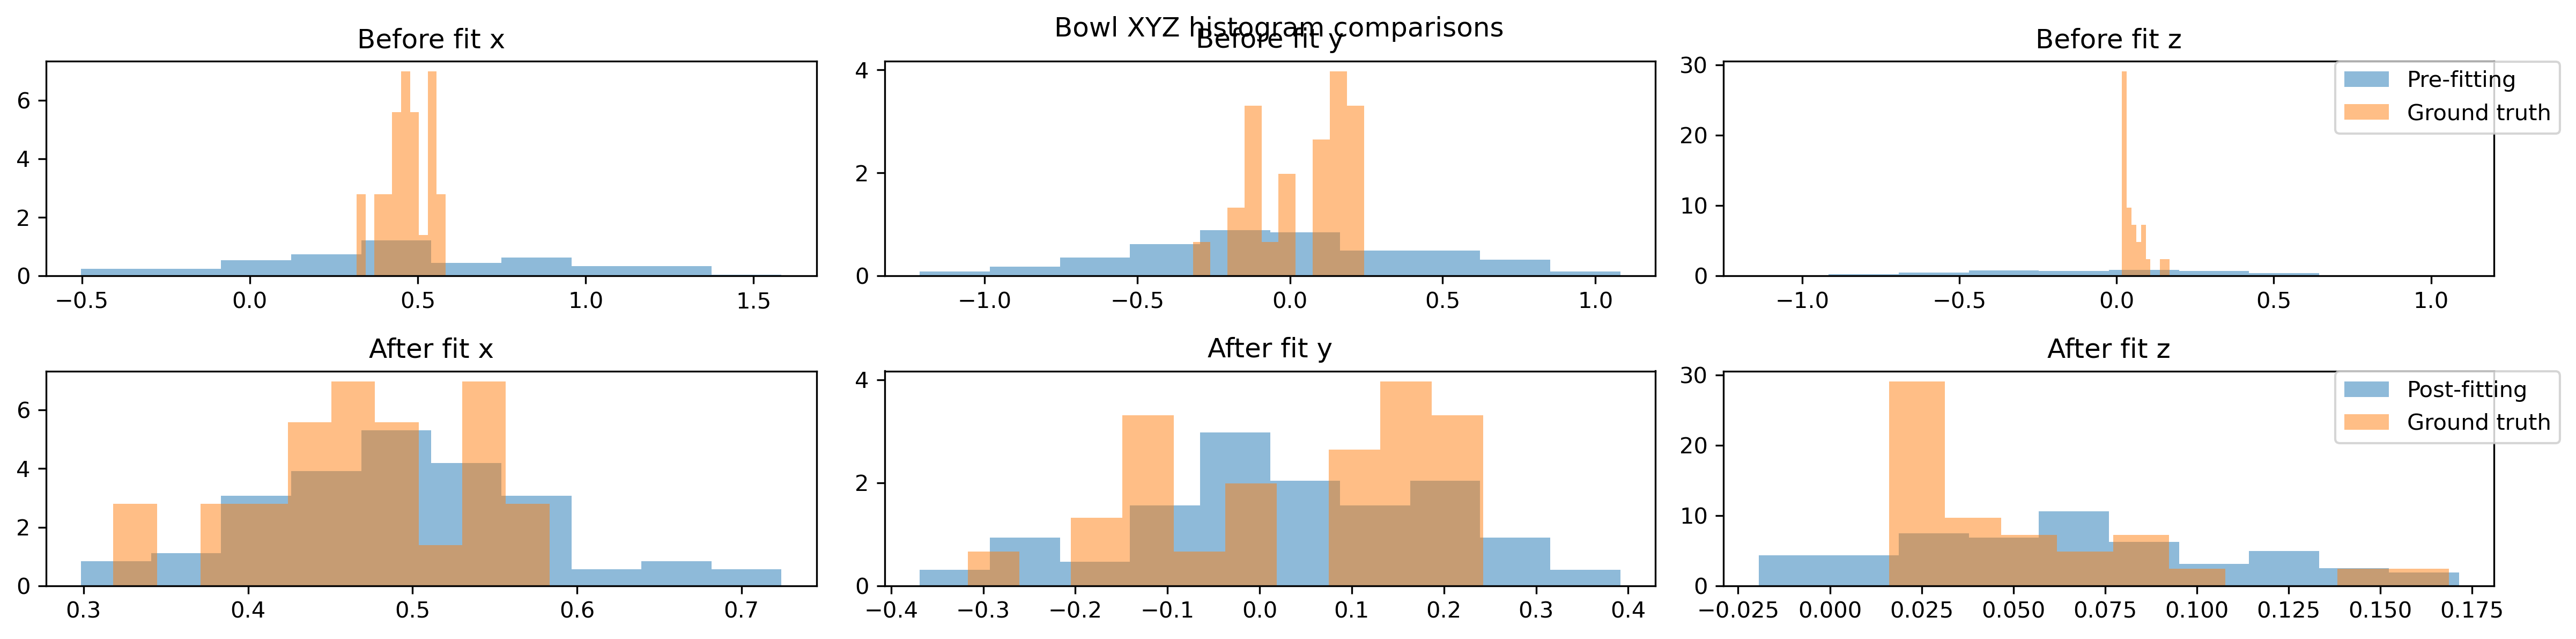

In [18]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(self, N_samples=100):
    pre_fit_samples= []
    self.grammar.load_state_dict(self.grammar_major_iters[0][0])
    for k in range(N_samples):
        pre_fit_samples.append(self.grammar.sample_tree(detach=True))
    fit_samples = []
    self.grammar.load_state_dict(self.grammar_major_iters[-1][-1])
    for k in range(N_samples):
        fit_samples.append(self.grammar.sample_tree(detach=True))

    for node_type in [Plate, Cup, Bowl]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(svi, N_samples=100)

In [20]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)